In [37]:
import pandas as pd
import numpy as np
import numpy
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import math
import random
import shap

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as ltb
import catboost as ctb
from skrebate import ReliefF

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold, cross_validate
seed(42)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from tabulate import tabulate

numpy.set_printoptions(threshold=sys.maxsize)

In [38]:
# read data
# Change data.csv to your file name
df = pd.read_csv('data.csv', index_col=[0])
response_variable = 'Dysphagia_at_M6_2plus'

In [39]:
# change outcome value, since it only contains 0's randomly make one third of it to 1's
total_rows = len(df)
half_rows_to_change = total_rows // 3
indices_to_change = random.sample(df.index.tolist(), half_rows_to_change)
df.loc[indices_to_change, response_variable] = 1

In [40]:
# get value count of response variable
df[response_variable].value_counts()

0    667
1    333
Name: Dysphagia_at_M6_2plus, dtype: int64

In [41]:
# this function will return variable list that have correlation more than cut(0.8)
def find_correlated_features(df, threshold=0.8):
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()
    
    # Calculate the average correlation for each feature
    avg_corr = corr_matrix.mean(axis=1)
    
    # Create an upper triangle mask to focus on unique pairs
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Initialize a list to store columns to drop
    drop_columns = []

    # Iterate through the upper triangle of the correlation matrix
    for row in range(len(upper_triangle) - 1):
        col_idx = row + 1
        for col in range(col_idx, len(upper_triangle)):
            # Check if correlation is above the threshold
            if upper_triangle.iloc[row, col] > threshold:
                # Compare average correlations to decide which feature to drop
                if avg_corr.iloc[row] > avg_corr.iloc[col]:
                    drop_columns.append(row)
                else:
                    drop_columns.append(col)
    # Convert the list of columns to drop into a set to get unique values
    drop_columns = set(drop_columns)
    # Get the names of correlated features
    correlated_features = df.columns[list(drop_columns)]
    
    return correlated_features



In [42]:
# Get the list of column names
variables = df.columns
thresh = 40 # Set the threshold for missing values
# Initialize lists to store selected and removed features
keep = [ ]
rem = []
correlated_variables = find_correlated_features(df)

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))

def preprocessing(df, test_size):
    
    # Convert categorical and boolean varialbles to numeric using LabelEncoder
    cat_cols = df.select_dtypes(include=['bool', 'object']).columns
    for col in cat_cols:
        labelencoder = LabelEncoder()
        df[col] = labelencoder.fit_transform(df[col])
        
    # remove rows with missing 'response variable'
    df = df.dropna(how='any', subset = [response_variable])
    print('Shape of data after excluding missing response:', np.shape(df))
    
    # TODO: Convert date variables (if any)
    # date variables are not in the simulated data
    
    # Delete columns with more than threshold NaN
    missing_per = get_missing_val_percentage(df)     
    keep = df.columns[missing_per <= thresh]
    df = df[keep]
    print('Shape of data after removing cols with less than %.2f percent values missing:' % (thresh), df.shape)
   
    # Remove correlated features 
    df = df.drop([x for x in correlated_variables if x in df.columns], axis=1)
    print('Shape of data after removing correlated features:', np.shape(df))
       
    
    # TODO: find outliers and remove
    
    # save preprocessed df to csv
    df.to_csv('preprocessed_1.csv')
    
    # split data
    random.seed(42)
    # Save original data set
    original = df
    Y = df[response_variable]
    X = df.drop(response_variable, axis=1)

    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, stratify = Y, random_state=123)
    
    # Data imputation starts here
    original_X_train = X_train
    original_X_test = X_test
    
    imputer = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
    # imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
    # imputeX = IterativeImputer(max_iter=5, random_state=0)
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    # Scale data: Scale imputed and non imputed data seperately.
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train_imputed = scaler.fit_transform(X_train_imputed)
    X_test_imputed = scaler.transform(X_test_imputed)
        
    # print unique value count of response variable in train and test set
    unique_train, counts_train = numpy.unique(Y_train.to_numpy(), return_counts=True)
    unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
    print("Train - ", unique_train, counts_train)
    print("Test - ", unique_test, counts_test)
    
    # Convert scaled arrays back to DataFrames
    X_train = pd.DataFrame(X_train, columns = original_X_train.columns, index=original_X_train.index)
    X_test = pd.DataFrame(X_test, columns = original_X_train.columns, index=original_X_test.index)
    
    X_train_imputed = pd.DataFrame(X_train_imputed, columns = original_X_train.columns, index=original_X_train.index)
    X_test_imputed = pd.DataFrame(X_test_imputed, columns = original_X_train.columns, index=original_X_test.index)
    
    return df, X_train, X_test, Y_train, Y_test, X, Y, X_train_imputed, X_test_imputed

df, X_train, X_test, Y_train, Y_test, X, Y, X_train_imputed, X_test_imputed = preprocessing(df, 0.25)


Shape of data after excluding missing response: (1000, 29)
Shape of data after removing cols with less than 40.00 percent values missing: (1000, 29)
Shape of data after removing correlated features: (1000, 21)
Train -  [0 1] [500 250]
Test -  [0 1] [167  83]


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [43]:
def cross_val(model, X_train, Y_train, n_splits=10):
    # Create an array to store balanced accuracy scores for each fold
    balacc_arr = []
    # Initialize StratifiedKFold with the number of splits
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

    # Loop through each fold in the cross-validation
    for i, (train_index, test_index) in enumerate(kf.split(X_train, Y_train)):
        # Split the training and testing data for this fold
        X_train1 = X_train.iloc[train_index]
        X_test1 = X_train.iloc[test_index]
        y_train1 = Y_train.iloc[train_index]
        y_test1 = Y_train.iloc[test_index]

        # Fit the model on the training data for this fold
        model.fit(X_train1, y_train1)
        # Get predicted probabilities for the positive class
        y_scores = model.predict_proba(X_test1)
        y_sc = y_scores[:, 1]
        # Calculate ROC curve and find optimal threshold for classification
        fpr, tpr, thresholds = roc_curve(y_test1, y_sc)
        optimal_idx = np.argmax(np.sqrt(tpr * (1 - fpr)))
        optimal_threshold = thresholds[optimal_idx]
        # Apply the optimal threshold for prediction and calculate balanced accuracy
        model_pred = (y_sc >= optimal_threshold).astype(int)
        confusion_matrix_model = confusion_matrix(y_test1, model_pred)
        acc_bal = confusion_matrix_model.diagonal() / confusion_matrix_model.sum(axis=1)
        balacc_arr.append(np.sum(acc_bal) / 2)
    
    # Calculate the variance of balanced accuracy scores across all folds
    variance_bal = np.var(balacc_arr, ddof=1)

    print("Cross validation variance Balance acc:", variance_bal)

    return model

In [44]:
# Plot ROC curve with the optimal threshold marked
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
# Find the optimal threshold based on ROC curve (G-mean)
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Display confusion matrix and accuracy results
def get_results(model, X, Y, pred):
    confusion_matrix_model = confusion_matrix(Y, pred)
    test_acc = model.score(X, Y)
    
    results_table = [
        ["Confusion Matrix", confusion_matrix_model],
        ["Accuracy", test_acc]
    ]
    
    print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Evaluate the model's performance metrics
def evaluate_model(model, X_test, Y_test, optimal_threshold):
    pred = (model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
    y_scores = model.predict_proba(X_test)
    score = round(roc_auc_score(Y_test, y_scores[:, 1]), 4)
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal() / confusion_matrix_model.sum(axis=1)
    avg_acc = np.sum(acc) / 2
    f1 = metrics.f1_score(pred, Y_test, average='micro')
    
    results_table = [
        ["Test ROC Score", score],
        ["Test Classwise Accuracy [Class 0, Class 1]", acc],
        ["Test Average Accuracy", avg_acc],
        ["Test F1 Score", f1]
    ]
    
    print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Train the model, evaluate on train and test sets, and return the trained model
def train_model(model, X_train, Y_train, X_test, Y_test):
    model = cross_val(model, X_train, Y_train)
    model = model.fit(X_train, Y_train)
    optimal_threshold = optimal_thresh(model, X_test, Y_test)
    pred = (model.predict_proba(X_test)[:, 1] >= optimal_threshold).astype(int)
    optimal_threshold_train = optimal_thresh(model, X_train, Y_train)
    pred_train = (model.predict_proba(X_train)[:, 1] >= optimal_threshold_train).astype(int)
    
    print('===== Train set =====')
    get_results(model, X_train, Y_train, pred_train)
    print('===== Test set =====')
    get_results(model, X_test, Y_test, pred)

    evaluate_model(model, X_test, Y_test, optimal_threshold_train)
    return model

In [45]:
# Initialize and train multiple machine learning models
def init(models, X_train, X_test, X_train_imputed, X_test_imputed, Y_train, Y_test):
    # Dictionary to store trained models
    trained_models = {}
    # Loop through each model in the list
    for model in models:
        # Set X_train and X_test based on the model type
        X_t = X_train
        X_te = X_test
        model_name = model.__class__.__name__
        # If model requires imputed data, update X_train and X_test accordingly
        if(model_name == 'AdaBoostClassifier' or model_name == 'RandomForestClassifier' or model_name == 'LogisticRegression'):
            X_t = X_train_imputed
            X_te = X_test_imputed
        print("Model:", model_name)
        
        # Train the model 
        trained_model = train_model(model, X_t, Y_train, X_te, Y_test)
        # Store the trained model in the dictionary
        trained_models[model_name] = trained_model
        
        print("\n" + "=" * 50 + "\n")
    return trained_models


# Without feature selection

In [46]:
# Tune parameters accordingly
xgboost =XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,
        max_depth = 4, 
        max_delta_step = 10,
        subsample = 0.5,
        colsample_bytree = 1,
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
        min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        alpha  = 0.08,
        num_class = 2
    )

lgb = ltb.LGBMClassifier(use_missing = True, 
                         learning_rate = 0.01,  # 0.045 (0.03)
                         scale_pos_weight=1,
                         max_depth =4, random_state=0 )

catboost = ctb.CatBoostClassifier(iterations=10,
                          learning_rate=0.1,
                          scale_pos_weight=0.4,
                          depth=3,
                          verbose=False)

adaboost = AdaBoostClassifier(random_state=0,
                              learning_rate=0.1,
                              n_estimators=1000,
                              algorithm = "SAMME.R") 

rf = RandomForestClassifier(max_depth=4,
                             n_estimators = np.shape(X_test)[1],
                             criterion = 'gini',
                             class_weight = 'balanced',
                              ccp_alpha=0.01,
                             random_state=0)

lr = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=4,
    class_weight='balanced',
    random_state=0,
    solver = 'saga'
)

# List of machine learning models to be trained
models = [xgboost, lgb, catboost, adaboost, rf, lr]

# Initialize and train the models using different data variations (original data and imputed data)
trained_models_case1 = init(models, X_train, X_test, X_train_imputed, X_test_imputed, Y_train, Y_test)


`use_label_encoder` is deprecated in 1.7.0.


Model: XGBClassifier
Cross validation variance Balance acc: 0.0017655555555555569
===== Train set =====
╒══════════════════╤════════════════════╕
│ Metric           │ Value              │
╞══════════════════╪════════════════════╡
│ Confusion Matrix │ [[485  15]         │
│                  │  [ 10 240]]        │
├──────────────────┼────────────────────┤
│ Accuracy         │ 0.9293333333333333 │
╘══════════════════╧════════════════════╛
===== Test set =====
╒══════════════════╤═══════════╕
│ Metric           │ Value     │
╞══════════════════╪═══════════╡
│ Confusion Matrix │ [[79 88]  │
│                  │  [25 58]] │
├──────────────────┼───────────┤
│ Accuracy         │ 0.672     │
╘══════════════════╧═══════════╛
╒════════════════════════════════════════════╤═════════════════════════╕
│ Metric                                     │ Value                   │
╞════════════════════════════════════════════╪═════════════════════════╡
│ Test ROC Score                             │ 0.58     

The max_iter was reached which means the coef_ did not converge


# With feature selection

In [47]:
# Get gender-specific stratified data subsets
def get_gender_stratified_data(gender, train_, test_, train_imputed_, test_imputed_, Y_train_, Y_test_, variable):
    # remove female specific features from male dataser
        
    # Create masks to identify rows with the given gender
    train_mask = train_[variable] == gender
    test_mask = test_[variable] == gender

    # Create masks for imputed data
    train_mask_imputed = train_imputed_[variable] == gender
    test_mask_imputed = test_imputed_[variable] == gender

    # Extract relevant features for the specified gender from the datasets
    X_train = train_.loc[train_mask].drop(response_variable, axis=1)
    X_test = test_.loc[test_mask].drop(response_variable, axis=1)

    # Extract features for imputed data
    X_train_imputed_ = train_imputed_.loc[train_mask_imputed].drop(response_variable, axis=1)
    X_test_imputed_ = test_imputed_.loc[test_mask_imputed].drop(response_variable, axis=1)

    # Extract labels for the specified gender from the response variable
    Y_train = Y_train_.loc[train_mask]
    Y_test = Y_test_.loc[test_mask]
   
    return X_train, X_train_imputed_, Y_train, X_test, X_test_imputed_, Y_test

In [48]:
# Divide the dataset into two based on sex before feature selection. Use this in sex-stratified models
df_app2 = df

# Data preprocessing
df_app2, X_train, X_test, Y_train, Y_test, X, Y,  X_train_imputed, X_test_imputed = preprocessing(df_app2, 0.25)

# Make copy of training and testing data
train_ = X_train.copy()
test_ = X_test.copy()
train_imputed_ = X_train_imputed.copy()
test_imputed_ = X_test_imputed.copy()
Y_train_ = Y_train.copy()
Y_test_ = Y_test.copy()

train_[response_variable] = Y_train_
test_[response_variable] = Y_test_
train_imputed_[response_variable] = Y_train_
test_imputed_[response_variable] = Y_test_

# get sex stratified data, Assign male female binar value accordingly (simulated data did not specify what are male/female codes)
female_X_train, female_X_train_imputed, female_Y_train, female_X_test, female_X_test_imputed, female_Y_test = get_gender_stratified_data(0, train_, test_, 
    train_imputed_, test_imputed_, Y_train_, Y_test_, 'SEX')
male_X_train, male_X_train_imputed, male_Y_train, male_X_test, male_X_test_imputed, male_Y_test = get_gender_stratified_data(1,  train_, test_,
    train_imputed_, test_imputed_, Y_train_, Y_test_, 'SEX')



Shape of data after excluding missing response: (1000, 21)
Shape of data after removing cols with less than 40.00 percent values missing: (1000, 21)
Shape of data after removing correlated features: (1000, 21)
Train -  [0 1] [500 250]
Test -  [0 1] [167  83]


In [49]:
# Set the number of best features to select. We tried with 10,15,20,25,30
best_n = 15 

# Function to get the most important features using ReliefF algorithm
def get_important_features(best_n, X_train_feat, Y_train_feat):
    original_X = X_train
    # Initialize the ReliefF feature selector. Tune parameters
    fs = ReliefF(n_features_to_select=best_n, n_neighbors=0.50)
    fs.fit(X_train_feat, Y_train_feat)

    # Create a dictionary to store feature scores
    feat_dict = {}
    # Store feature scores in the dictionary
    for feature_name, feature_score in zip(original_X.columns,
                                           fs.feature_importances_):
        feat_dict[feature_name] = feature_score

    # Sort and select the most important features
    feat_names = []
    sorted_feat_dict = sorted(feat_dict.items(), key=lambda x: x[1], reverse=True)

    # Extract the top 'best_n' features
    best = sorted_feat_dict[: best_n]

    # Store the names of the selected features
    for i in best:
        feat_names.append(i[0])

    return feat_names

features = get_important_features(best_n, X_train.to_numpy(), Y_train.to_numpy())
display(features)

['Primary_tumor_location_pharynx',
 'PT_Dmean_PCM_superior',
 'DELTA_NTCP',
 'NSTAGE',
 'NTCP_PT',
 'Dysphagia_at_baseline_2plus',
 'TSTAGE',
 'RT_Dysphagia_at_M6_2plus',
 'SEX',
 'RT_Dmean_parotid_low',
 'RT_Dmean_PCM_medius',
 'PT_Dysphagia_at_M6_2plus',
 'PT_Dmean_parotid_low',
 'RT_Dmean_PCM_inferior',
 'PT_Dmean_parotid_high']

In [50]:
# Select columns with selected features
X_train_feat = X_train[features]
X_test_feat = X_test[features]

X_train_feat_imputed_ = X_train_imputed[features]
X_test_feat_imputed_ = X_test_imputed[features]

# Train models using the specified list of machine learning models
# Here I used same models in approach 1
# TODO: Create new instances of each model here, and then perform tuning and training on them anew

# List of machine learning models to train
models = [xgboost, lgb, catboost, adaboost, rf, lr]

trained_models_case2 = init(models, X_train_feat, X_test_feat, X_train_feat_imputed_, X_test_feat_imputed_, Y_train, Y_test)


Model: XGBClassifier
Cross validation variance Balance acc: 0.0024544444444444457
===== Train set =====
╒══════════════════╤═════════════╕
│ Metric           │ Value       │
╞══════════════════╪═════════════╡
│ Confusion Matrix │ [[476  24]  │
│                  │  [  9 241]] │
├──────────────────┼─────────────┤
│ Accuracy         │ 0.92        │
╘══════════════════╧═════════════╛
===== Test set =====
╒══════════════════╤═══════════╕
│ Metric           │ Value     │
╞══════════════════╪═══════════╡
│ Confusion Matrix │ [[80 87]  │
│                  │  [28 55]] │
├──────────────────┼───────────┤
│ Accuracy         │ 0.66      │
╘══════════════════╧═══════════╛
╒════════════════════════════════════════════╤═════════════════════════╕
│ Metric                                     │ Value                   │
╞════════════════════════════════════════════╪═════════════════════════╡
│ Test ROC Score                             │ 0.5679                  │
├──────────────────────────────────────

# Sex-stratified models with selected features

In [51]:
data = df_app2.copy()
# Count gender samples
def get_gender_count(df):
    df['id'] = range(1, 1001) # add id to group by gender
    gender_groupby = df.groupby('SEX', as_index=False).agg(total= ('id','count'))
    print(gender_groupby)
    df.drop('id', axis=1, inplace=True) # drop previously added id column
    
get_gender_count(data)

   SEX  total
0    0    754
1    1    246


In [52]:
# Select columns with selected features in sex-stratified data

best_n = 14 # number of features 

# get most important features for female dataset
features = get_important_features(best_n, female_X_train.to_numpy(), female_Y_train.to_numpy())
print(features)

# Filtering data with selected features
female_X_train_feat = female_X_train[features]
female_X_test_feat = female_X_test[features]

female_X_train_imputed_feat = female_X_train_imputed[features]
female_X_test_imputed_feat = female_X_test_imputed[features]

['Primary_tumor_location_pharynx', 'PT_Dmean_PCM_superior', 'DELTA_NTCP', 'NTCP_PT', 'NSTAGE', 'RT_Dysphagia_at_M6_2plus', 'RT_Dmean_parotid_low', 'Dysphagia_at_baseline_2plus', 'TSTAGE', 'RT_Dmean_PCM_medius', 'PT_Dmean_parotid_low', 'PT_Dysphagia_at_M6_2plus', 'RT_Dmean_PCM_inferior', 'Primary_tumor_location_oral_cavity']


In [53]:
# Train models with female's data 
# Here I used same models in approach 1
# TODO: Create new instances of each model here, and then perform tuning and training on them anew
models = [xgboost, lgb, catboost, adaboost, rf, lr]
    
trained_models_case3_female = init(models, female_X_train_feat, female_X_test_feat,
                                   female_X_train_imputed_feat, female_X_test_imputed_feat, 
                                   female_Y_train, female_Y_test)

Model: XGBClassifier
Cross validation variance Balance acc: 0.003370130626345558
===== Train set =====
╒══════════════════╤════════════════════╕
│ Metric           │ Value              │
╞══════════════════╪════════════════════╡
│ Confusion Matrix │ [[366  16]         │
│                  │  [  9 182]]        │
├──────────────────┼────────────────────┤
│ Accuracy         │ 0.9336823734729494 │
╘══════════════════╧════════════════════╛
===== Test set =====
╒══════════════════╤════════════════════╕
│ Metric           │ Value              │
╞══════════════════╪════════════════════╡
│ Confusion Matrix │ [[57 63]           │
│                  │  [23 38]]          │
├──────────────────┼────────────────────┤
│ Accuracy         │ 0.6298342541436464 │
╘══════════════════╧════════════════════╛
╒════════════════════════════════════════════╤═════════════════════════╕
│ Metric                                     │ Value                   │
╞════════════════════════════════════════════╪════════════

Cross validation variance Balance acc: 0.004602094934789019
===== Train set =====
╒══════════════════╤════════════════════╕
│ Metric           │ Value              │
╞══════════════════╪════════════════════╡
│ Confusion Matrix │ [[241 141]         │
│                  │  [ 80 111]]        │
├──────────────────┼────────────────────┤
│ Accuracy         │ 0.5706806282722513 │
╘══════════════════╧════════════════════╛
===== Test set =====
╒══════════════════╤══════════════════╕
│ Metric           │ Value            │
╞══════════════════╪══════════════════╡
│ Confusion Matrix │ [[59 61]         │
│                  │  [16 45]]        │
├──────────────────┼──────────────────┤
│ Accuracy         │ 0.56353591160221 │
╘══════════════════╧══════════════════╛
╒════════════════════════════════════════════╤═════════════════════════╕
│ Metric                                     │ Value                   │
╞════════════════════════════════════════════╪═════════════════════════╡
│ Test ROC Score      

In [54]:
best_n = 14 # number of features 

# get most important features for male dataset
features = get_important_features(best_n, male_X_train.to_numpy(), male_Y_train.to_numpy())
print(features)

# Filtering data with selected features
male_X_train_feat = male_X_train[features]
male_X_test_feat = male_X_test[features]

male_X_train_imputed_feat = male_X_train_imputed[features]
male_X_test_imputed_feat = male_X_test_imputed[features]

['Primary_tumor_location_pharynx', 'PT_Dmean_PCM_superior', 'NSTAGE', 'Dysphagia_at_baseline_2plus', 'DELTA_NTCP', 'RT_Dmean_PCM_medius', 'TSTAGE', 'RT_Dmean_parotid_low', 'NTCP_PT', 'PT_Dmean_parotid_high', 'RT_Dysphagia_at_M6_2plus', 'PT_Dysphagia_at_M6_2plus', 'Primary_tumor_location_oral_cavity', 'RT_Dmean_PCM_inferior']


In [55]:
# Train male models with male data
# Here I used same models in approach 1
# TODO: Create new instances of each model here, and then perform tuning and training on them anew
models = [xgboost, lgb, catboost, adaboost, rf, lr]

trained_models_case3_male = init(models, male_X_train_feat, male_X_test_feat,
                                   male_X_train_imputed_feat, male_X_test_imputed_feat, 
                                   male_Y_train, male_Y_test)


Model: XGBClassifier
Cross validation variance Balance acc: 0.008151113406795224
===== Train set =====
╒══════════════════╤════════════════════╕
│ Metric           │ Value              │
╞══════════════════╪════════════════════╡
│ Confusion Matrix │ [[114   4]         │
│                  │  [  1  58]]        │
├──────────────────┼────────────────────┤
│ Accuracy         │ 0.9548022598870056 │
╘══════════════════╧════════════════════╛
===== Test set =====
╒══════════════════╤════════════════════╕
│ Metric           │ Value              │
╞══════════════════╪════════════════════╡
│ Confusion Matrix │ [[23 24]           │
│                  │  [ 7 15]]          │
├──────────────────┼────────────────────┤
│ Accuracy         │ 0.5652173913043478 │
╘══════════════════╧════════════════════╛
╒════════════════════════════════════════════╤═════════════════════════╕
│ Metric                                     │ Value                   │
╞════════════════════════════════════════════╪════════════

# SHAP plots

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


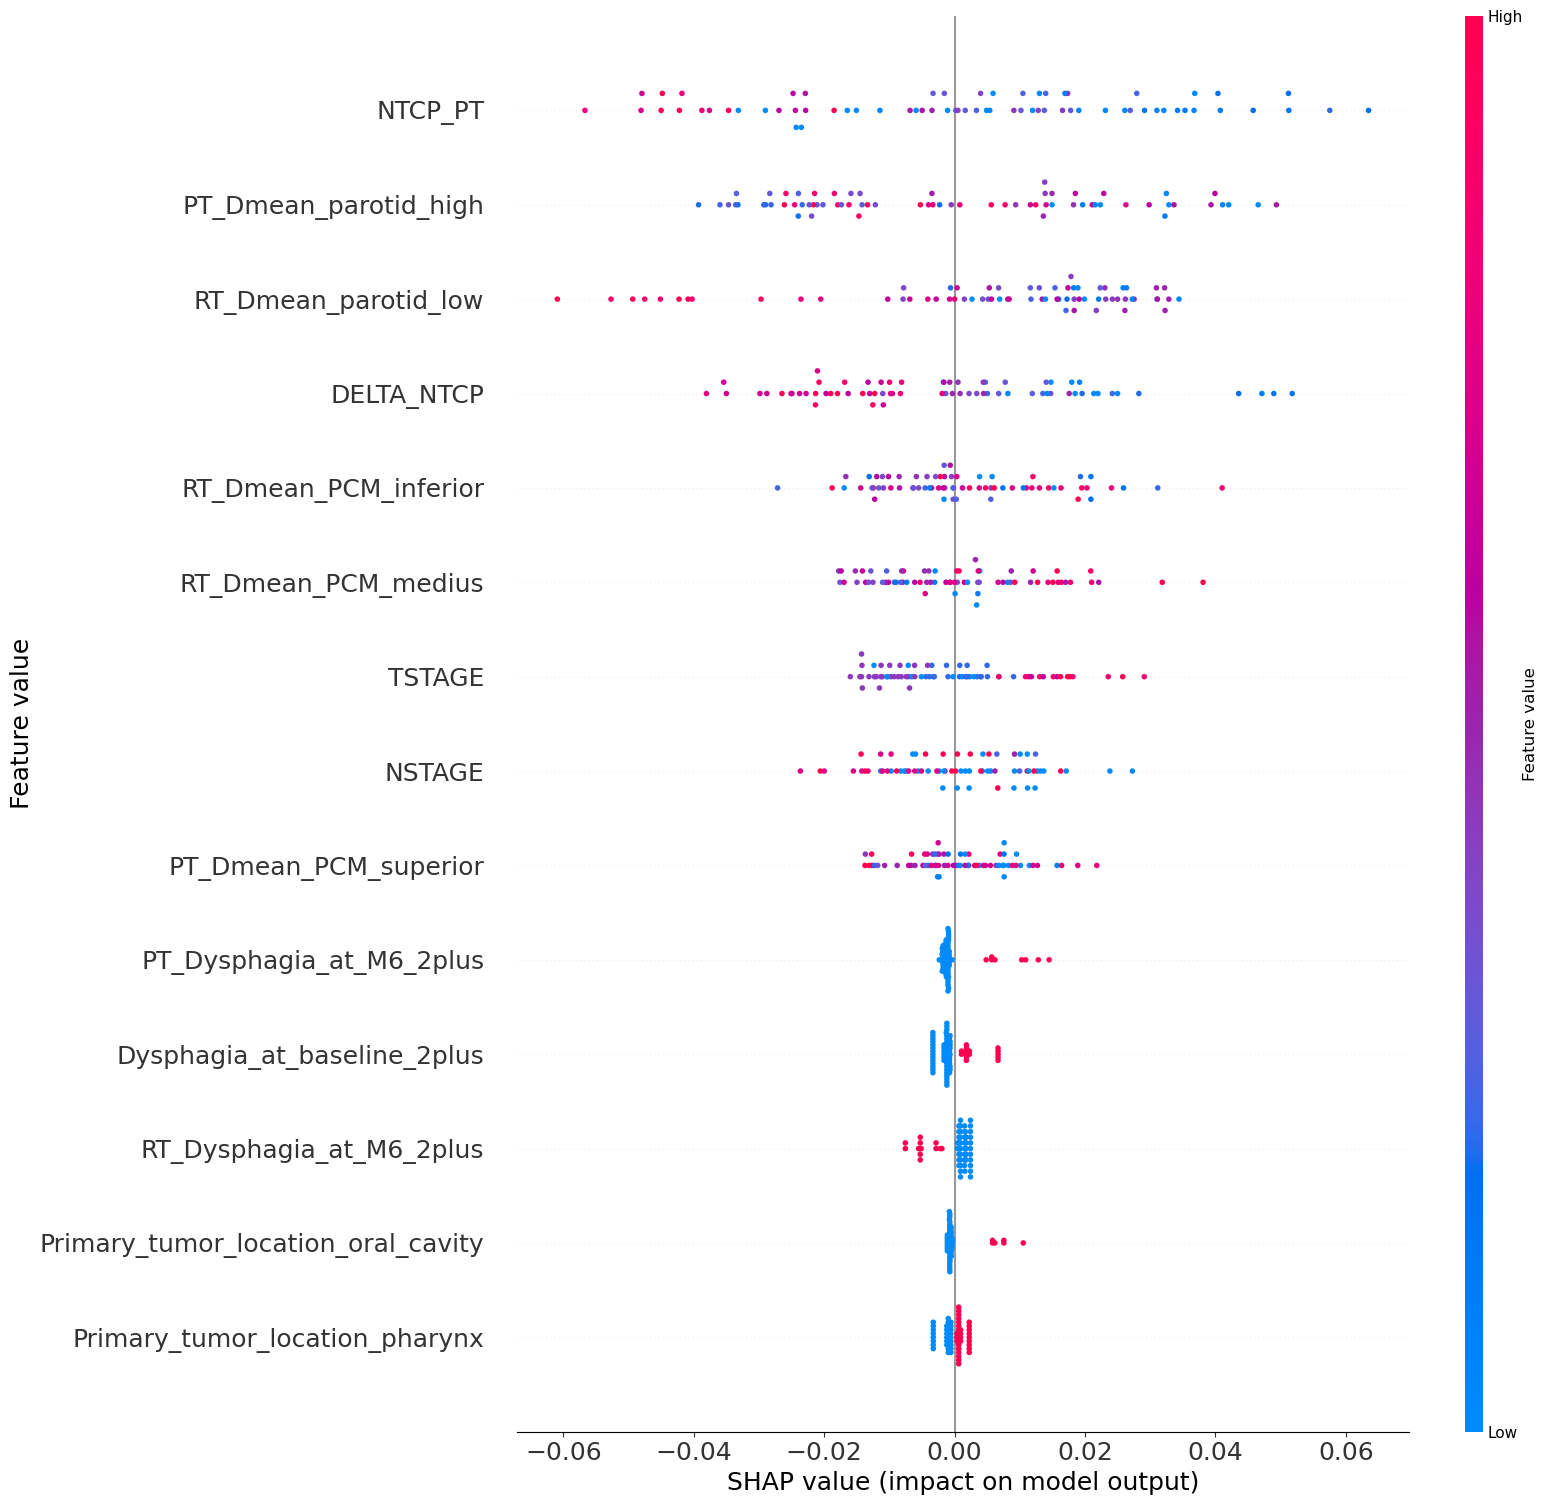

In [56]:
# Global SHAP plots

# Select the model you want to explain (XGBClassifier in this case for male sex-stratified models)
selected_model = trained_models_case3_male['XGBClassifier']

# Create an explainer using SHAP
explainer = shap.Explainer(selected_model, male_X_train_feat)

# Calculate SHAP values for the data using the explainer
shap_values = explainer(male_X_test_feat) # use compatible X_train data to the selected model

# Create a summary plot of SHAP values. You can change feature names properly by sending feature name list to feature_names parameter
shap.summary_plot(shap_values[:, :, 1], plot_type="dot", max_display=25, show=False, plot_size=[15,15], feature_names=features)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=18)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=18)
cb_ax = fig.axes[0] 
cb_ax.tick_params(labelsize=18)
cb_ax.set_ylabel("Feature value", fontsize=18)
# Save the plot
plt.savefig('Male_Global_SHAP_plot.jpeg' ,bbox_inches='tight', dpi=300)
plt.show()


In [71]:
# Local SHAP plot - Force plot

row_to_show = 60
data_for_prediction = male_X_test_feat.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired

shap.initjs()
shap_values = explainer(male_X_test_feat.iloc[[row_to_show]]) # use compatible X_train data to the selected model
shap.force_plot(explainer.expected_value[1], shap_values.values[:,:,1], data_for_prediction, link='logit')


In [69]:
# Modified the force plot to improve clarity and highlight feature interactions
def local_shap_plot(df, data, shap_values):
    
    # Set the threshold to filter out small SHAP values. here it's set to 0. change it
    threshold = 0.00
    sv_ = []
    features_ = []
    
    # Map feature names to corresponding data values
    mapping = dict(zip(df.columns.tolist(), list(data)))
    feature_data = [f"{feature}={mapping[feature]}" for feature in mapping]

    # Filter out zero SHAP values and corresponding feature data
    for sv, feature in zip(shap_values, feature_data):
        sv_.append(sv)
        features_.append(feature)

    # Sort the features and SHAP values in descending order
    sorted_features = [feature for _, feature in sorted(zip(sv_, features_), reverse=True)]
    sorted_sv = sorted(sv_, reverse=True)
    
    # Assign colors based on positive or negative SHAP values
    colors = ['crimson' if sv >= 0 else 'dodgerblue' for sv in sorted_sv]

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.tick_params(labelsize=18)
    ax.barh(sorted_features, sorted_sv, color=colors, left=threshold)

    # Show top values at the top of the plot
    ax.invert_yaxis()
    plt.xlabel('SHAP value', fontsize=18)
    plt.ylabel('Feature value', fontsize=18)
    plt.savefig('MS_Male_Local.jpeg', bbox_inches='tight', dpi=300)
    plt.show()



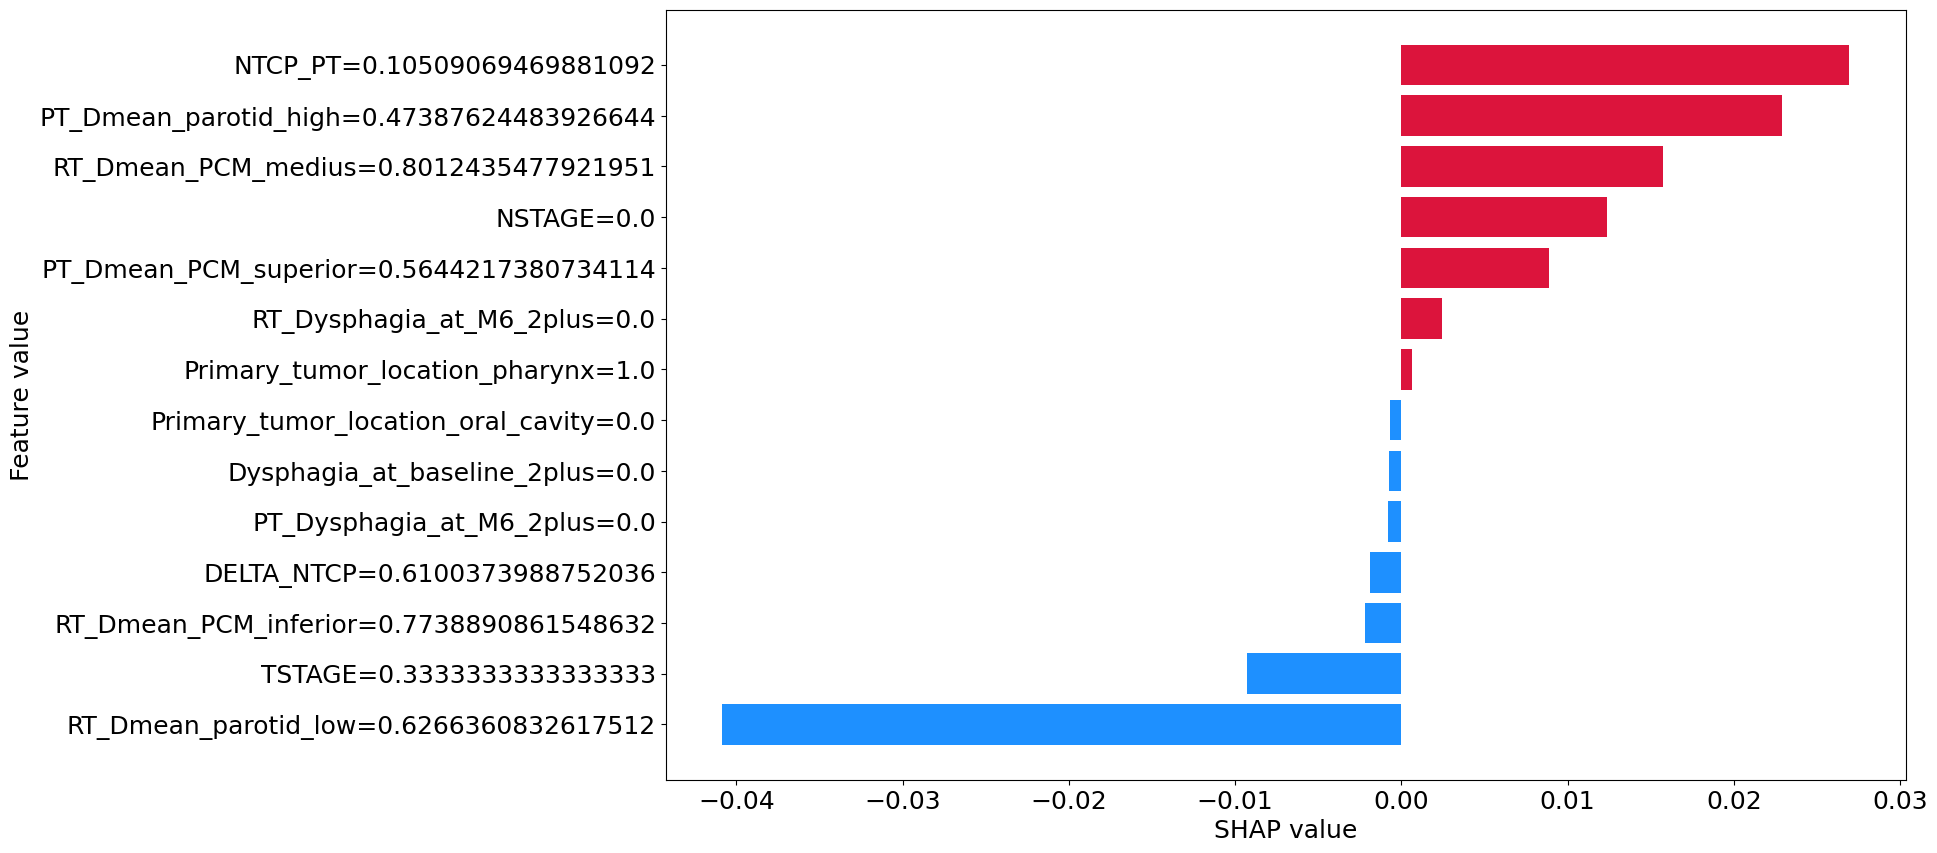

In [70]:
row_to_show = 60
data_for_prediction = male_X_test_feat.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired

# calculate shap values
shap_values = explainer(male_X_test_feat.iloc[[row_to_show]])

# Extract the SHAP values for class 1 ( change to 0 if needed)
shap_values_class0 = shap_values.values[:, :, 1][0]

local_shap_plot(male_X_test_feat, data_for_prediction, shap_values_class0)